In [2]:
import math, numpy as np
from sklearn import preprocessing
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997
2019-09-04,209.479996,207.320007,208.389999,209.190002,19188100.0,209.190002
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999
2019-09-06,214.419998,212.509995,214.050003,213.259995,19350800.0,213.259995


In [3]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail()

Date
2019-08-30    198.498685
2019-09-03    198.564745
2019-09-04    198.682279
2019-09-05    198.841507
2019-09-06    198.996962
Name: Adj Close, dtype: float64

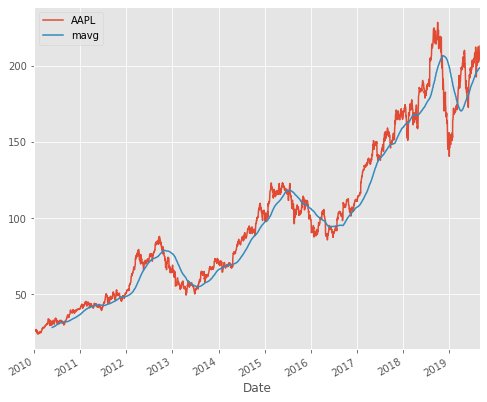

In [4]:
%matplotlib inline

# Adjusting the size of matplotlib

mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

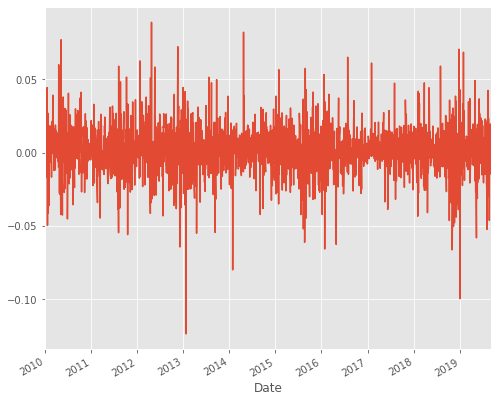

In [5]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [6]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2009-12-31,26.272409,10.557920,308.832428,96.994438,24.072418
2010-01-04,26.681330,10.781219,312.204773,98.142967,24.443624
2010-01-05,26.727465,10.837044,310.829926,96.957375,24.451517
2010-01-06,26.302330,10.781219,302.994293,96.327530,24.301458
2010-01-07,26.253704,11.339470,295.940735,95.994110,24.048725


In [7]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.321588,0.463748,0.387132,0.458490
GE,0.321588,1.000000,0.332293,0.437894,0.362097
GOOG,0.463748,0.332293,1.000000,0.407854,0.539378
IBM,0.387132,0.437894,0.407854,1.000000,0.492904
MSFT,0.458490,0.362097,0.539378,0.492904,1.000000


Text(0, 0.5, 'Returns GE')

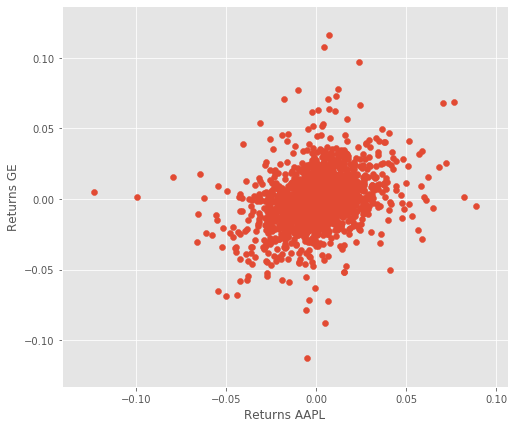

In [8]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

In [9]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [10]:

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [12]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [14]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [15]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.9636411283717573
The quadratic regression 2 confidence is  0.9660831839739316
The quadratic regression 3 confidence is  0.9667091231954268
The knn regression confidence is  0.9520003333604408


In [25]:
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan

In [26]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]


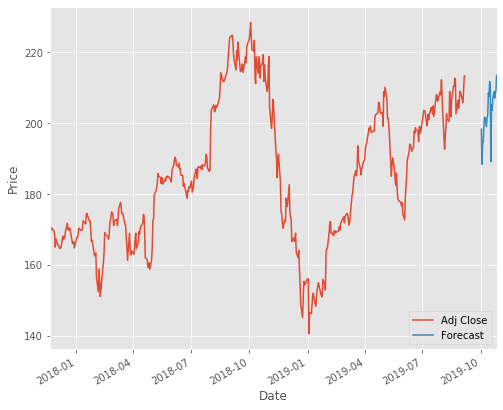

In [27]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()